# Code-along 2025-01-15 Build an AI Movie Night Recommendation Tool


In this code-along, we will be building an AI Movie Night Recommendation Tool! 

To do this, we will be using two data sets: 
- Movies metadata: A data set containing metadata of about 9000 movies (title, description, etc.)
- User ratings: A data set containing ratings of how much someone liked a movie. 

We will be building towards our end goal by covering the following tasks: 
- Understanding the data set by doing some basic exploratory analysis 
- Building a first recommender based on movie popularity or movie ratings 
- Personalising recommendations by exploiting user ratings 
- Leveraging LLMs to calculate similarity between movies 
- Generating a recommendation by writing what kind of movies you'd like to see 
- Putting it all together into one single recommendation tool

This code-along is aimed at anyone just starting to code by showing how you can build something useful by simply writing prompts to analyse data sets. The code generated is sufficiently challenging, however, for the more seasoned data person to play around with.

## Task 1: Import the ratings and movie metadata and explore it. 

The data is contained in two CSV files named `movies_metadata.csv` and `ratings.csv`

`movies_metadata` contains the following columns: 

- `movie_id`: Unique identifier of each movie. 
- `title`: Title of the movie. 
- `overview`: Short description of the movie. 
- `vote_average`: Average score the movie got.
- `vote_count`: Total number of votes the movie got. 

`ratings` contains the following columns: 

- `user_id`: Unique identifier of the person who rated the movie. 
- `movie_id`: Unique identifier of the movie. 
- `rating`: Value between 0 and 10 indicating how much the person liked the movie. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8) #Adjust configuration of plot

In [2]:
# Read the movies_metadata file
movies_metadata = pd.read_csv('movies_metadata.csv')

# Read the ratings file
ratings = pd.read_csv('ratings.csv')

In [3]:
# Count how many unique movies there are
unique_movies = movies_metadata['movie_id'].nunique()

# Count how many unique users have rated how many unique movies
unique_users = ratings['user_id'].nunique()
unique_rated_movies = ratings['movie_id'].nunique()

print(f"Number of unique movies: {unique_movies}")
print(f"Number of unique users: {unique_users}")

Number of unique movies: 9010
Number of unique users: 671


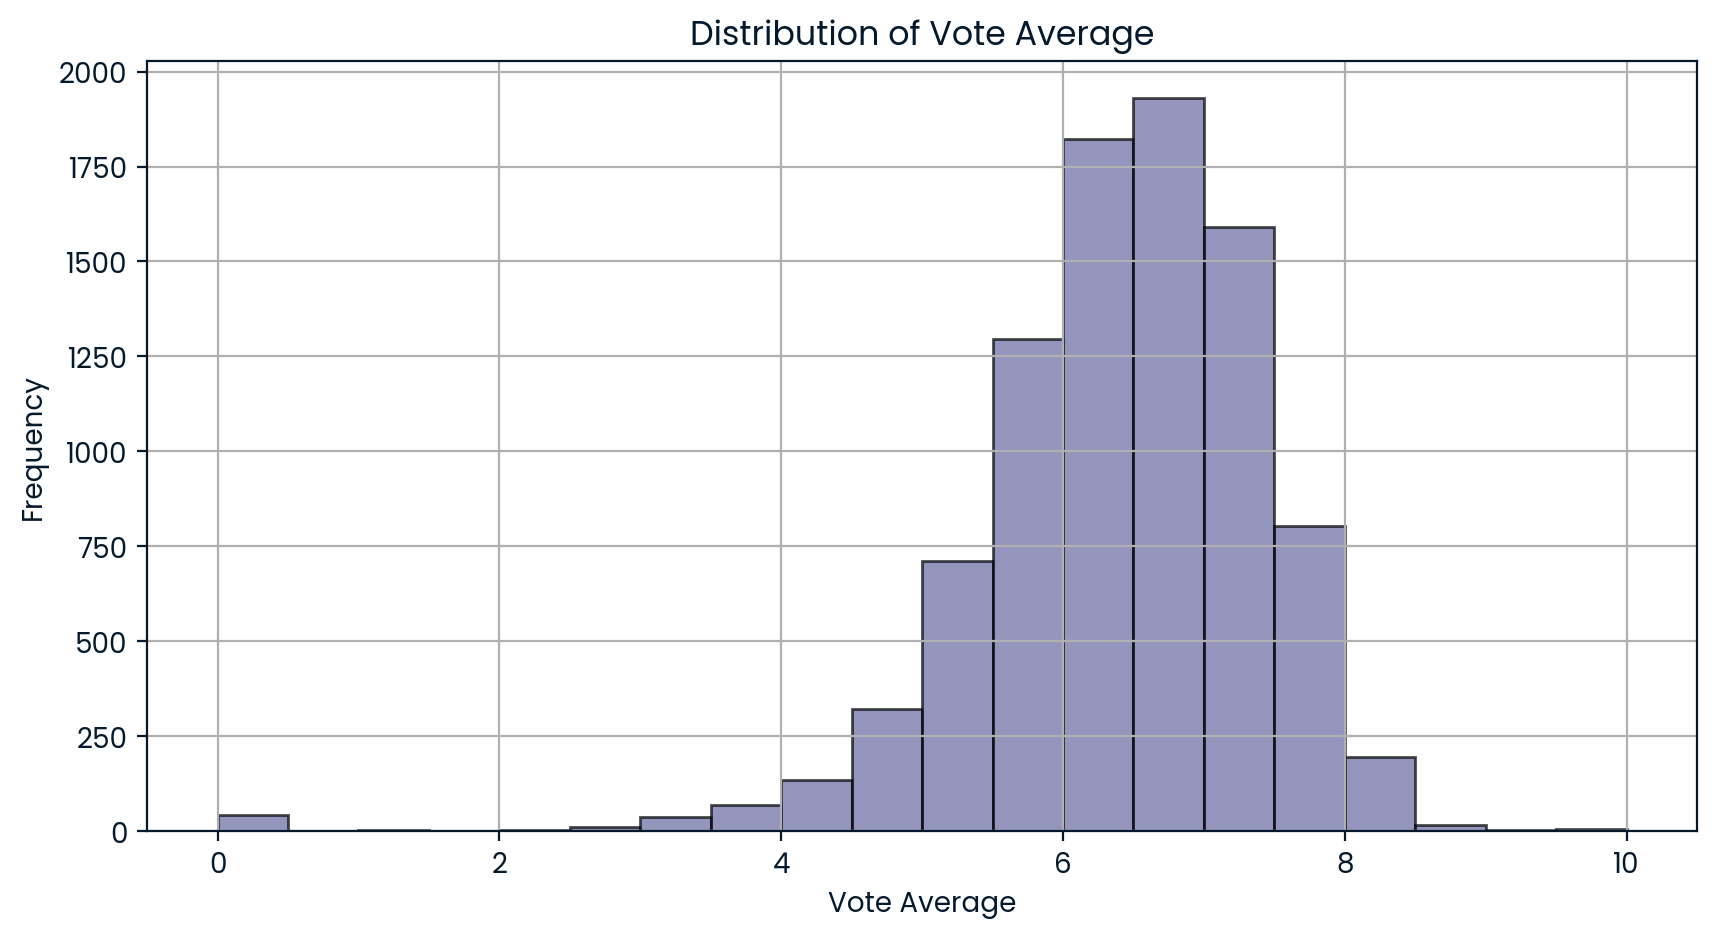

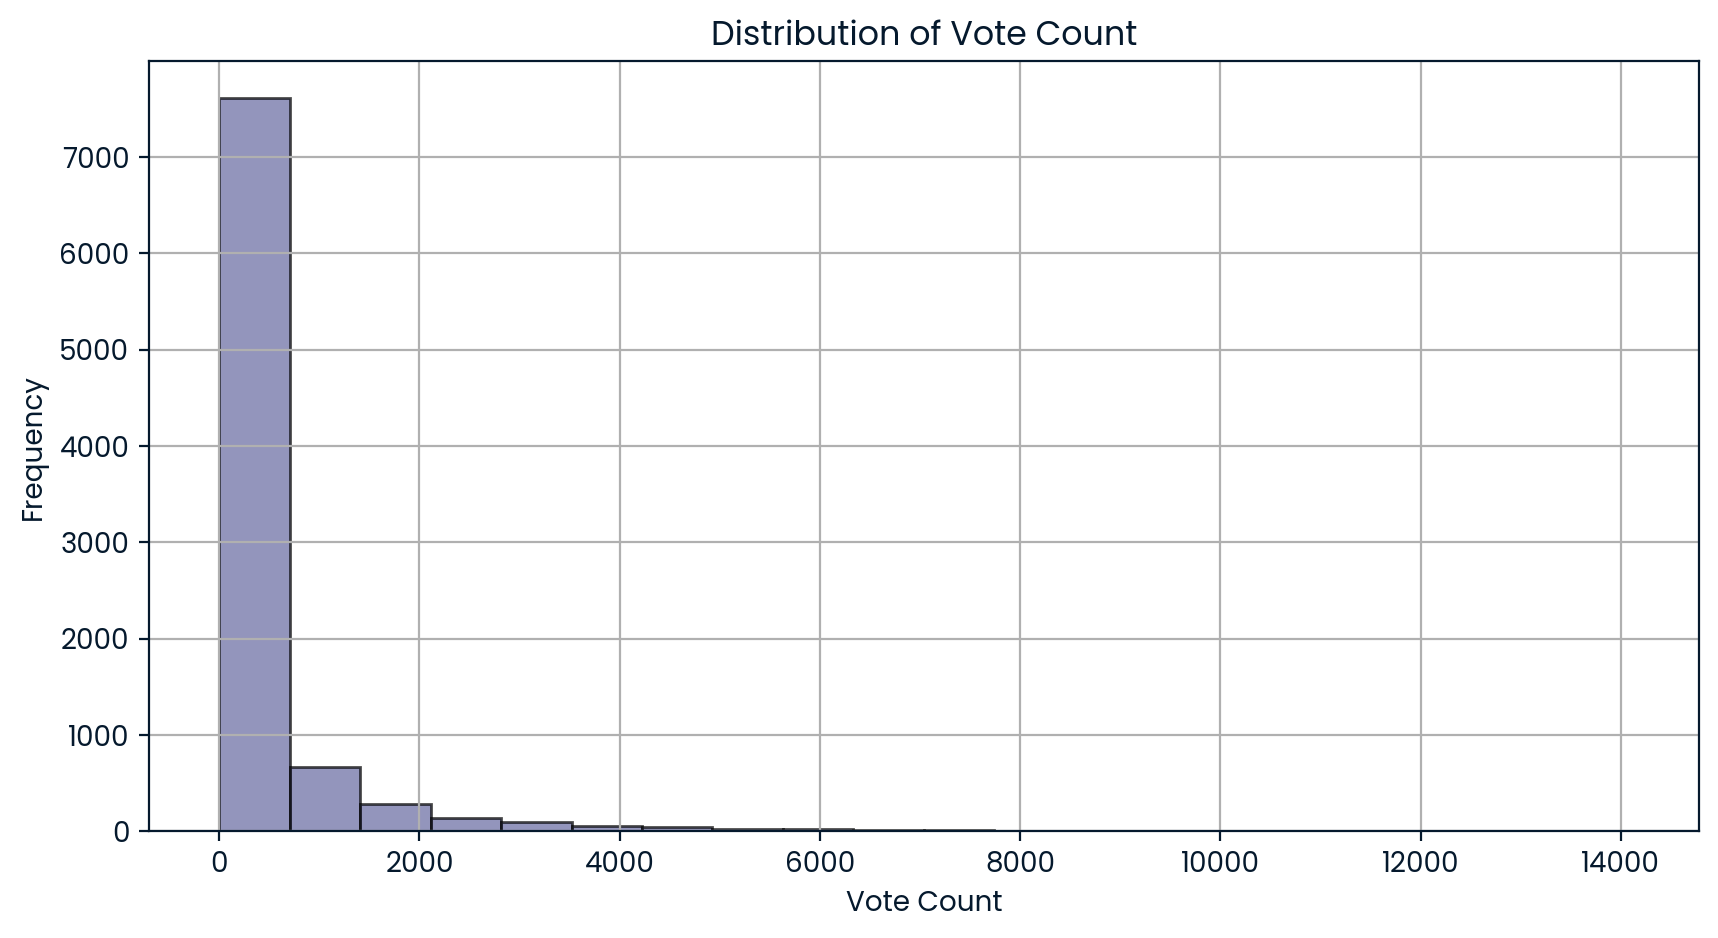

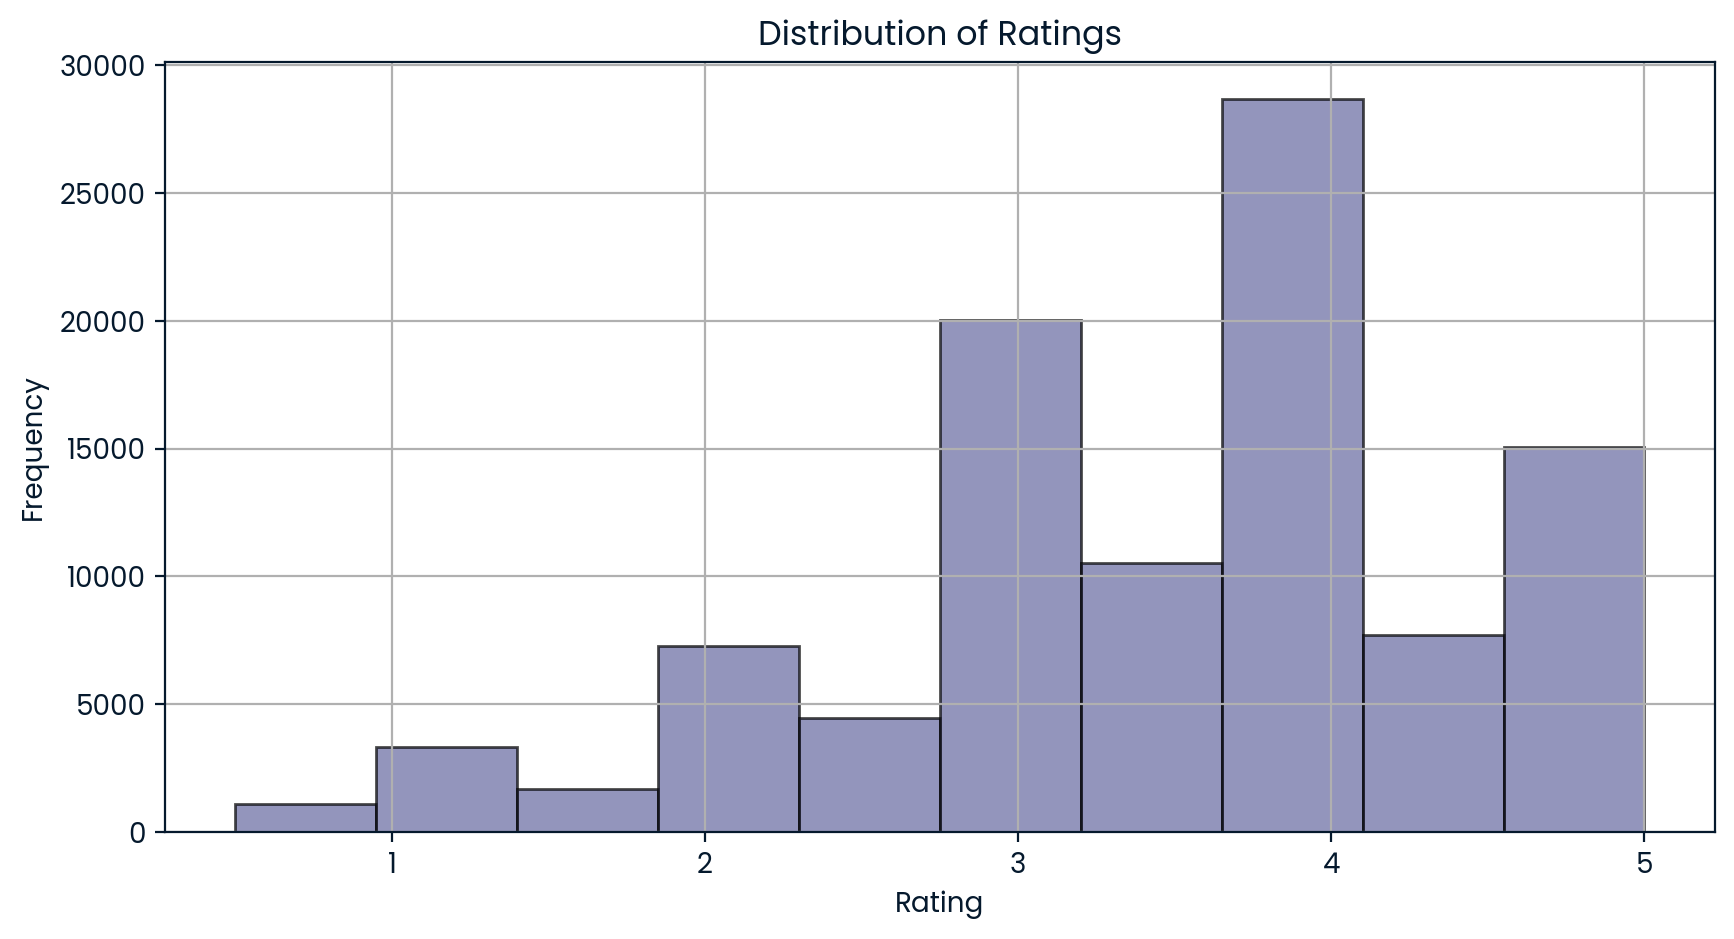

In [4]:
# Visualise the vote_average column
plt.figure(figsize=(10, 5))
plt.hist(movies_metadata['vote_average'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualise the vote_count column
plt.figure(figsize=(10, 5))
plt.hist(movies_metadata['vote_count'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualise the distribution of the rating column
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'].dropna(), bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Task 2: Simple recommender based on popularity or highest rating

In short, a recommender is any system that generates suggestions for an end user. We will start with creating the simplest recommender, one that ranks all movies according to the highest average score, or the highest number of votes. 

This kind of recommender generates the same output for anyone using it. 

In [5]:
def simple_recommender(movies_metadata, criterion='vote_average', top_n=10):
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    
    # Sort the movies based on the specified criterion
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    
    # Select the top N movies
    recommended_movies = recommended_movies[['movie_id', 'title', 'overview', criterion]].head(top_n)
    
    return recommended_movies


In [6]:

# Example usage:
top_movies_by_average = simple_recommender(movies_metadata, criterion='vote_average', top_n=10)
top_movies_by_count = simple_recommender(movies_metadata, criterion='vote_count', top_n=10)

# Display the top movies
top_movies_by_average
top_movies_by_count

,movie_id,title,overview,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,9634.0


## Task 3: Generate recommendations based on user ratings

We already created a very simple first recommender, but we haven't touched our user data yet! How can this help us? When you watched a movie you liked, you might want to learn which other movies other users liked that also watched that movie. This is where the user data comes in. We can use the ratings to infer which movies are similar to a movie you have already watched! 

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def collaborative_recommender(ratings, movies_metadata, movie_title, top_n=10):
    # Merge ratings with movie metadata to get movie titles
    ratings_with_titles = ratings.merge(movies_metadata[['movie_id', 'title']], on='movie_id')
    
    # Create a pivot table with users as rows, movies as columns, and ratings as values
    user_movie_matrix = ratings_with_titles.pivot_table(index='user_id', columns='title', values='rating')
    
    # Fill NaN values with 0 (assuming unrated movies have a rating of 0)
    user_movie_matrix.fillna(0, inplace=True)
    
    # Compute the cosine similarity matrix
    movie_similarity = cosine_similarity(user_movie_matrix.T)
    
    # Convert the similarity matrix into a DataFrame
    movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)
    
    # Get the similarity scores for the specified movie
    similar_movies = movie_similarity_df[movie_title].sort_values(ascending=False)
    
    # Exclude the movie itself from the recommendations
    similar_movies = similar_movies.drop(movie_title)
    
    # Get the top N similar movies
    top_similar_movies = similar_movies.head(top_n)
    
    return top_similar_movies

# Example usage:
# movie_title = "The Godfather"
# top_similar_movies = collaborative_recommender(ratings, movies_metadata, movie_title, top_n=10)
# top_similar_movies

## Task 4: Generate embeddings based on the movie descriptions

So far, we already created two recommenders! One that didn't take into account your preferences, and one that suggested movies based on similarity to a movie you already saw. Now, we will get creative and let you write a summary of the kind of move you'd like to watch to get recommendations back! 

In order to do this, we will rely on a concept called *embeddings*. In a nutshell, embeddings are numerical representations of a piece of text and they are critical to the success of the most recent generation of AI models, like ChatGPT. We will take the description of our movies and convert these to their embedded form. 

In [9]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load the movies metadata
movies_metadata = pd.read_csv('movies_metadata.csv')

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each movie overview
movies_metadata['embeddings'] = movies_metadata['overview'].apply(lambda x: model.encode(x) if pd.notnull(x) else None)

# Display the first few rows to verify
movies_metadata.head()

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/211k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/368k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

,movie_id,title,overview,vote_average,vote_count,embeddings
0,95765.0,Cinema Paradiso,"A filmmaker recalls his childhood, when he fel...",8.2,834.0,"[-0.054256108, -0.03165526, -0.021484591, 0.01..."
1,67116.0,The French Connection,Tough narcotics detective 'Popeye' Doyle is in...,7.4,435.0,"[-0.10362895, -0.08074168, -0.08822192, -0.022..."
2,80801.0,The Gods Must Be Crazy,Misery is brought to a small group of Sho in t...,7.1,251.0,"[-0.0051899403, 0.10656534, 0.00037665927, 0.0..."
3,96446.0,Willow,Fearful of a prophecy stating that a girl chil...,6.9,484.0,"[-0.012960954, 0.00087635795, -0.050599147, 0...."
4,112697.0,Clueless,"Shallow, rich and socially successful Cher is ...",6.9,828.0,"[0.00983128, 0.0113212345, 0.07493014, 0.00525..."


## Task 5: Use embedding simillarity to generate recommendations

Now we are ready to create a new recommender function where we submit a description of a movie we want to watch and get recommendations back. 

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(description, movies_metadata, model, top_n=5):
    # Generate embedding for the user description
    user_embedding = model.encode(description)
    
    # Calculate cosine similarity between user embedding and movie embeddings
    movies_metadata['similarity'] = movies_metadata['embeddings'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0] if x is not None else 0)
    
    # Sort movies by similarity and get top n
    recommendations = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return recommendations[['title', 'overview', 'similarity']]

# Example usage
user_description = "A thrilling adventure in space with lots of action and special effects."
recommendations = recommend_movies(user_description, movies_metadata, model, top_n=5)
recommendations

,title,overview,similarity
6869,King Kong,An adventure film about a film crew in search ...,0.522331
5618,Step Into Liquid,No special effects. No stuntmen. No stereotype...,0.520695
673,Oceans,"An ecological drama/documentary, filmed throug...",0.512388
3511,You Only Live Twice,A mysterious space craft kidnaps a Russian and...,0.505929
4793,Wet Hot American Summer,"The setting is Camp Firewood, the year 1981. I...",0.475099


## Task 6: Put it all together into a single function

In this final task, we will be putting all previous recommenders together into one single function that will allow you to generate an awesome movie night! 

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming the necessary dataframes and models are already loaded:
# movies_df, ratings_df, movie_embeddings, etc.

def recommend_movies(option, movie_title=None, user_prompt=None, top_n=10):
    if option == 'vote_average' or option == 'vote_count':
        # Recommender based on vote_average or vote_count
        if option == 'vote_average':
            recommended_movies = movies_df.sort_values(by='vote_average', ascending=False).head(top_n)
        else:
            recommended_movies = movies_df.sort_values(by='vote_count', ascending=False).head(top_n)
        return recommended_movies[['title', option]]
    
    elif option == 'similar_movies':
        # Recommender based on ratings data
        if movie_title is None:
            raise ValueError("movie_title must be provided for similar_movies option")
        
        movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
        movie_vector = ratings_df.iloc[movie_idx].values.reshape(1, -1)
        similarity_scores = cosine_similarity(ratings_df, movie_vector).flatten()
        similar_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]
        similar_movies = movies_df.iloc[similar_indices]
        return similar_movies[['title', 'similarity_score']]
    
    elif option == 'embedding_similarity':
        # Recommender based on movie embeddings
        if user_prompt is None:
            raise ValueError("user_prompt must be provided for embedding_similarity option")
        
        user_vector = np.array(user_prompt).reshape(1, -1)
        similarity_scores = cosine_similarity(movie_embeddings, user_vector).flatten()
        similar_indices = similarity_scores.argsort()[-top_n:][::-1]
        similar_movies = movies_df.iloc[similar_indices]
        return similar_movies[['title', 'similarity_score']]
    
    else:
        raise ValueError("Invalid option. Choose from 'vote_average', 'vote_count', 'similar_movies', 'embedding_similarity'.")

# Example usage:
# recommend_movies('vote_average', top_n=5)
# recommend_movies('similar_movies', movie_title='Inception', top_n=5)
# recommend_movies('embedding_similarity', user_prompt=[0.1, 0.2, 0.3, ...], top_n=5)